In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

* In this notebook, we will put these two errors into perspective and show how
they can help us know if our model generalizes, overfits, or underfits.

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [3]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

# Overfitting vs Underfitting

In [4]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits = 30, test_size = 0.2)
cv_results = cross_validate(regressor, data, target, cv = cv,
                            scoring = "neg_mean_absolute_error",
                            return_train_score = True, n_jobs = 2)
cv_results = pd.DataFrame(cv_results)

* The cross-validation used the negative mean absolute error. We transform the negative mean error to positive mean absolute error

In [5]:
import pandas as pd

scores = pd.DataFrame()
scores[["train error", "test_error"]] = -cv_results[["train_score", "test_score"]]

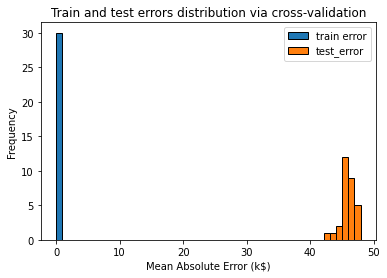

In [6]:
import matplotlib.pyplot as plt

scores.plot.hist(bins = 50, edgecolor = "black")
plt.xlabel("Mean Absolute Error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Here, we observe a **small training error** (actually zero), meaning that
the model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the
model is **over-fitting**: the model has memorized many variations of the
training set that could be considered "noisy" because they do not generalize
to help us make good prediction on the test set.


## Validation curve

Some model hyperparameters are usually the key to go from a model that
underfits to a model that overfits, hopefully going through a region were we
can get a good balance between the two. We can acquire knowledge by plotting
a curve called the validation curve. This curve can also be applied to the
above experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` parameter is used to control the
tradeoff between under-fitting and over-fitting.

In [7]:
%%time

from sklearn.model_selection import validation_curve

max_depth = [1,5,10,15,20,25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name = "max_depth", param_range = max_depth,
    cv = cv, scoring = "neg_mean_absolute_error", n_jobs = 2)

train_errors, test_errors = -train_scores, test_scores

CPU times: user 540 ms, sys: 30.8 ms, total: 570 ms
Wall time: 11.7 s


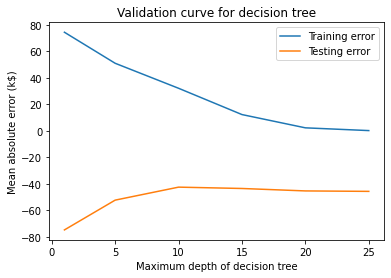

In [8]:
# Now we will show the validation curve by plotting the training and testing errors
plt.plot(max_depth, train_errors.mean(axis = 1), label = "Training error")
plt.plot(max_depth, test_errors.mean(axis = 1), label = "Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

For `max_depth` < 10, the decision tree underfits. The testing is very low while the training error is very high. The model is somewhat constrained
The region around `max_depth` = 10 corresponds to the parameter to the parameter for which the decision tree generalizes best. It is flexible enough to capture a fraction of the variable target that generalizes, while not memorizing all of the noise in the target
For `max_depth` > 10, the decision tree overfits. The training error becomes small while the testing error increases gradually. In this region, the models create decisions 

* We should also look at the standard deviation to assess the dispersion of the score. We can repeat the same plot as  before but this time, we will add some information to show the standard deviation of the errors as well.

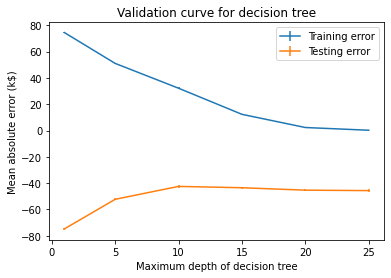

In [9]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")